In [1]:
# !pip install -U "ray[air]"
# python3 -m pip install --upgrade pip setuptools wheel
# export GITHUB_USERNAME="KaranHC"  # <-- CHANGE THIS to your username

# git clone https://github.com/GokuMohandas/Made-With-ML.git .
# git remote set-url origin https://github.com/$GITHUB_USERNAME/Made-With-ML.git
# git checkout -b dev
# export PYTHONPATH=$PYTHONPATH:$PWD  # so we can import modules from our scripts

In [2]:
import ray

In [3]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()

ray.init()

2023-09-06 20:04:55,878	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.6.0
Dashboard:,http://127.0.0.1:8265


In [4]:
ray.cluster_resources()

{'node:127.0.0.1': 1.0,
 'memory': 3933460071.0,
 'object_store_memory': 1966730035.0,
 'CPU': 8.0,
 'node:__internal_head__': 1.0}

In [5]:
# Workers (1 g4dn.xlarge)
num_workers = 1
resources_per_worker={"CPU":3}#{"CPU": 3, "GPU": 1}

In [6]:
import pandas as pd


In [7]:
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC).sample(500)
df.head()

,id,created_on,title,description,tag
254,855,2020-05-14 12:32:20,Fake new detection Pytorch,Fake News Detection by Learning Convolution Fi...,natural-language-processing
487,1645,2020-06-29 17:16:17,Using Data Science Pipelines for Disaster Resp...,Uses ETL and ML pipeline to build an NLP syste...,natural-language-processing
510,1710,2020-07-05 05:47:35,NLP-task-visualizer-app,This application designed with streamlit libra...,natural-language-processing
72,269,2020-04-06 22:46:54,Attention Mechanism,"Main concepts behind Attention, including an i...",natural-language-processing
214,707,2020-05-05 03:36:50,The Big Bad NLP Database,A collection of 400+ NLP datasets with papers ...,natural-language-processing


In [8]:
df.shape

(500, 5)

In [9]:
from sklearn.model_selection import train_test_split


In [10]:
df.tag.value_counts()


tag
natural-language-processing    206
computer-vision                197
other                           65
mlops                           32
Name: count, dtype: int64

In [11]:
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [12]:
train_df.tag.value_counts()


tag
natural-language-processing    165
computer-vision                157
other                           52
mlops                           26
Name: count, dtype: int64

In [13]:
0.8/test_size

4.0

In [14]:
val_df.tag.value_counts() * int((1-test_size) / test_size)


tag
natural-language-processing    164
computer-vision                160
other                           52
mlops                           24
Name: count, dtype: int64

In [15]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [16]:
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 206),
 ('computer-vision', 197),
 ('other', 65),
 ('mlops', 32)]

In [17]:
all_tags.most_common(),zip(*all_tags.most_common())

([('natural-language-processing', 206),
  ('computer-vision', 197),
  ('other', 65),
  ('mlops', 32)],
 <zip at 0x2c228c6e1c0>)

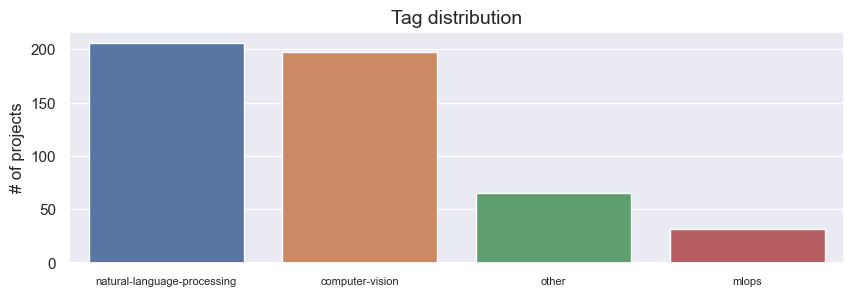

In [18]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=8)
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

In [19]:
tags, tag_counts

(('natural-language-processing', 'computer-vision', 'other', 'mlops'),
 (206, 197, 65, 32))

In [20]:
tags, tag_counts = zip(*all_tags.most_common())


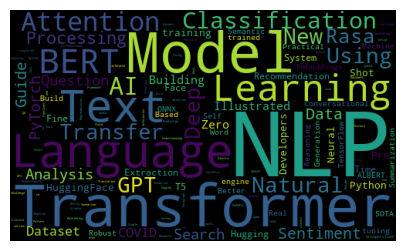

In [21]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)


In [22]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [23]:
df["text"] = df.title + " " + df.description


In [24]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sri.karan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [26]:
df.head(2)

,id,created_on,title,description,tag,text
254,855,2020-05-14 12:32:20,Fake new detection Pytorch,Fake News Detection by Learning Convolution Fi...,natural-language-processing,Fake new detection Pytorch Fake News Detection...
487,1645,2020-06-29 17:16:17,Using Data Science Pipelines for Disaster Resp...,Uses ETL and ML pipeline to build an NLP syste...,natural-language-processing,Using Data Science Pipelines for Disaster Resp...


In [27]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Fake new detection Pytorch Fake News Detection by Learning Convolution Filters through Contextualized Attention.
fake new detection pytorch fake news detection learning convolution filters contextualized attention


In [28]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
254,fake new detection pytorch fake news detection...,natural-language-processing
487,using data science pipelines disaster response...,natural-language-processing
510,nlp task visualizer app application designed s...,natural-language-processing
72,attention mechanism main concepts behind atten...,natural-language-processing
214,big bad nlp database collection 400 nlp datase...,natural-language-processing


In [29]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [30]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()


,text,tag
254,fake new detection pytorch fake news detection...,2
487,using data science pipelines disaster response...,2
510,nlp task visualizer app application designed s...,2
72,attention mechanism main concepts behind atten...,2
214,big bad nlp database collection 400 nlp datase...,2


In [31]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [32]:
index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['natural-language-processing',
 'natural-language-processing',
 'natural-language-processing',
 'natural-language-processing',
 'natural-language-processing']

In [33]:
import numpy as np
from transformers import BertTokenizer

In [34]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."

encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]
[CLS] transfer learning with transformers for text classification. [SEP]


In [35]:
encoded_inputs["input_ids"]

array([[  102,  2268,  1904,   190, 29155,   168,  3267,  2998,   205,
          103]])

In [36]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [37]:
tokenize(df.head(1))


{'ids': array([[  102, 17444, 30107,   758,  1995,  5702,  2112,   255, 17444,
         30107,  9340,  1995,  1904, 12524,  7347, 11695,   645,  3577,
           103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2], dtype=int64)}

In [38]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [39]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True  # deterministic


In [40]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)

ds.take(1)

2023-09-06 20:05:13,929	INFO read_api.py:374 -- To satisfy the requested parallelism of 16, each read task output will be split into 16 smaller blocks.
2023-09-06 20:05:13,945	INFO dataset.py:2180 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2023-09-06 20:05:13,949	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle]
2023-09-06 20:05:13,950	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 20:05:13,953	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

[{'id': 428,
  'created_on': datetime.datetime(2020, 4, 10, 4, 57, 53),
  'title': 'AiLight: Automatic  Highlighting Using BERT',
  'description': 'Automatically highlight pdfs using BERT embeddings and clustering.\nhttps://anishthite.github.io/ailight',
  'tag': 'natural-language-processing'}]

In [41]:
import re
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import ray
from ray.data import Dataset
from ray.data.preprocessor import Preprocessor
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# from madewithml.config import STOPWORDS


def load_data(dataset_loc: str, num_samples: int = None) -> Dataset:
    """Load data from source into a Ray Dataset.

    Args:
        dataset_loc (str): Location of the dataset.
        num_samples (int, optional): The number of samples to load. Defaults to None.

    Returns:
        Dataset: Our dataset represented by a Ray Dataset.
    """
    ds = ray.data.read_csv(dataset_loc)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds


def stratify_split(
    ds: Dataset,
    stratify: str,
    test_size: float,
    shuffle: bool = True,
    seed: int = 1234,
) -> Tuple[Dataset, Dataset]:
    """Split a dataset into train and test splits with equal
    amounts of data points from each class in the column we
    want to stratify on.

    Args:
        ds (Dataset): Input dataset to split.
        stratify (str): Name of column to split on.
        test_size (float): Proportion of dataset to split for test set.
        shuffle (bool, optional): whether to shuffle the dataset. Defaults to True.
        seed (int, optional): seed for shuffling. Defaults to 1234.

    Returns:
        Tuple[Dataset, Dataset]: the stratified train and test datasets.
    """

    def _add_split(df: pd.DataFrame) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Naively split a dataframe into train and test splits.
        Add a column specifying whether it's the train or test split."""
        train, test = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=seed)
        train["_split"] = "train"
        test["_split"] = "test"
        return pd.concat([train, test])

    def _filter_split(df: pd.DataFrame, split: str) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Filter by data points that match the split column's value
        and return the dataframe with the _split column dropped."""
        return df[df["_split"] == split].drop("_split", axis=1)

    # Train, test split with stratify
    grouped = ds.groupby(stratify).map_groups(_add_split, batch_format="pandas")  # group by each unique value in the column we want to stratify on
    train_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "train"}, batch_format="pandas")  # combine
    test_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "test"}, batch_format="pandas")  # combine

    # Shuffle each split (required)
    train_ds = train_ds.random_shuffle(seed=seed)
    test_ds = test_ds.random_shuffle(seed=seed)

    return train_ds, test_ds


def clean_text(text: str, stopwords: List = STOPWORDS) -> str:
    """Clean raw text string.

    Args:
        text (str): Raw text to clean.
        stopwords (List, optional): list of words to filter out. Defaults to STOPWORDS.

    Returns:
        str: cleaned text.
    """
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub(" ", text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  # remove links

    return text


def tokenize(batch: Dict) -> Dict:
    """Tokenize the text input in our batch using a tokenizer.

    Args:
        batch (Dict): batch of data with the text inputs to tokenize.

    Returns:
        Dict: batch of data with the results of tokenization (`input_ids` and `attention_mask`) on the text inputs.
    """
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))


def preprocess(df: pd.DataFrame, class_to_index: Dict) -> Dict:
    """Preprocess the data in our dataframe.

    Args:
        df (pd.DataFrame): Raw dataframe to preprocess.
        class_to_index (Dict): Mapping of class names to indices.

    Returns:
        Dict: preprocessed data (ids, masks, targets).
    """
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs


class CustomPreprocessor(Preprocessor):
    """Custom preprocessor class."""

    def _fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def _transform_pandas(self, batch):  # could also do _transform_numpy
        return preprocess(batch, class_to_index=self.class_to_index)

In [42]:
df.head(2)

,text,tag
254,fake new detection pytorch fake news detection...,2
487,using data science pipelines disaster response...,2


In [43]:
def _add_split(df: pd.DataFrame) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Naively split a dataframe into train and test splits.
        Add a column specifying whether it's the train or test split."""
        train, test = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=seed)
        train["_split"] = "train"
        test["_split"] = "test"
        return pd.concat([train, test])


In [44]:
def _filter_split(df: pd.DataFrame, split: str) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Filter by data points that match the split column's value
        and return the dataframe with the _split column dropped."""
        
        return df[df["_split"] == split].drop("_split", axis=1)

In [45]:
ds.groupby("tag").map_groups(_add_split, batch_format="pandas").map_batches(_filter_split, fn_kwargs={"split": "train"}, batch_format="pandas")

2023-09-06 20:05:17,273	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-09-06 20:05:17,275	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 20:05:17,277	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

MapBatches(_filter_split)
+- MapBatches(group_fn)
   +- Sort
      +- RandomShuffle
         +- Dataset(
               num_blocks=16,
               num_rows=764,
               schema={
                  id: int64,
                  created_on: timestamp[s],
                  title: string,
                  description: string,
                  tag: string
               }
            )

In [46]:
# grouped = ds.groupby(stratify).map_groups(_add_split, batch_format="pandas")  # group by each unique value in the column we want to stratify on
# train_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "train"}, batch_format="pandas")  # combine
# test_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "test"}, batch_format="pandas")  # combine

# # Shuffle each split (required)
# train_ds = train_ds.random_shuffle(seed=seed)
# test_ds = test_ds.random_shuffle(seed=seed)

In [47]:
import sys
# sys.path.append("..")
# import  stratify_split
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

In [48]:
train_ds.take(1)

2023-09-06 20:05:20,606	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle]
2023-09-06 20:05:20,607	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 20:05:20,608	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Running: 0.0/8.0 CPU, 0.0/0.0 GPU, 0.21 MiB/468.9 MiB object_store_memory 0:   0%|          | 0/3 [00:00<?, ?i…

[{'id': 2223,
  'created_on': Timestamp('2020-08-26 04:21:37'),
  'title': 'AxCell',
  'description': 'Automatic Extraction of Results from Machine Learning Papers',
  'tag': 'computer-vision'}]

In [49]:
tags = train_ds.unique(column="tag")
tags

2023-09-06 20:05:23,578	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-09-06 20:05:23,580	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 20:05:23,581	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2023-09-06 20:05:25,040	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-09-06 20:05:25,067	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 20:05:25,076	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

['computer-vision', 'mlops', 'natural-language-processing', 'other']

In [50]:
class_to_index = {tag: i for i, tag in enumerate(tags)}


In [51]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(
  preprocess,
  fn_kwargs={"class_to_index": class_to_index},
  batch_format="pandas")
sample_ds.show(1)

2023-09-06 20:05:27,163	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-09-06 20:05:27,164	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 20:05:27,165	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

{'ids': array([ 102, 2189, 2782, 6487, 4220,  545, 3997, 1904, 5995,  103,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


In [52]:
import pandas as pd


In [53]:
# Load training data
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
train_df = pd.read_csv(DATASET_LOC).sample(500)
train_df.head()

,id,created_on,title,description,tag
754,2418,2020-10-02 10:16:17,Top Research Papers from the ECML-PKDD 2020 Co...,ECML-PKDD -> selectionof the best reaesch papers,other
90,307,2020-04-07 20:11:29,GLUE Explained: Understanding BERT Through Ben...,In this post we take a look at an important NL...,natural-language-processing
644,2062,2020-08-06 12:38:55,Predict Vehicle Speed From Dash Cam Video,A series of experiments attempting to predict ...,computer-vision
75,272,2020-04-06 23:38:26,The Annotated GPT-2,GPT-2 explained with visualization and PyTorch...,natural-language-processing
233,800,2020-05-11 00:44:10,Feature Stores for ML,List of production ML groups and their open-so...,mlops


In [54]:
# Unique labels
tags = train_df.tag.unique().tolist()
tags

['other', 'natural-language-processing', 'computer-vision', 'mlops']

In [55]:
# Load inference dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_df = pd.read_csv(HOLDOUT_LOC)

In [56]:
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.metrics import precision_recall_fscore_support
import time
from tqdm import tqdm

In [57]:
# # from dotenv import load_dotenv
# import openai

In [58]:
# import pandas  as pd
# # from langchain.llms import OpenAI
# from dotenv import load_dotenv

# import openai,os
# load_dotenv(r'/home/niq/hcsr2001/code/Nearest NaN Experiments_zero_touch/.env')
# openai_api_key = os.getenv("OPENAI_API_KEY")

# assert openai_api_key, "ERROR: Azure OpenAI Key is missing"
# openai.api_key = openai_api_key

# openai.api_base = os.getenv("OpenAiService")
# openai.api_type = "azure"
# openai.api_version =os.getenv("OpenAiVersion")
# davincimodel= os.getenv("OpenAiDavinci")
# active_loop_token=os.getenv("ACTIVELOOP_TOKEN")
# embedding_model=os.getenv("OpenAiEmbedding")
# chat_ai=os.getenv("ChatAI")#
# HUGGINGFACEHUB_API_TOKEN=os.getenv("HUGGINGFACEHUB_API_TOKEN")

In [59]:
# openai.api_key = openai_api_key

In [60]:
# # Query OpenAI endpoint
# system_content = "you only answer in rhymes"  # system content (behavior)
# assistant_content = ""  # assistant content (context)
# user_content = "how are you"  # user content (message)
# response = openai.ChatCompletion.create(
#     engine=chat_ai,
#     messages=[
#         {"role": "system", "content": system_content},
#         {"role": "assistant", "content": assistant_content},
#         {"role": "user", "content": user_content},
#     ],
# )
# print (response.to_dict()["choices"][0].to_dict()["message"]["content"])

In [61]:
# response

In [62]:
# def get_tag(model, system_content="", assistant_content="", user_content=""):
#     try:
#         # Get response from OpenAI
#         response = openai.ChatCompletion.create(
#             engine=model,
#             messages=[
#                 {"role": "system", "content": system_content},
#                 {"role": "assistant", "content": assistant_content},
#                 {"role": "user", "content": user_content},
#             ],
#         )
#         predicted_tag = response.to_dict()["choices"][0].to_dict()["message"]["content"]
#         return predicted_tag

#     except (openai.error.ServiceUnavailableError, openai.error.APIError) as e:
#         return None

In [63]:
# # Get tag
# model = chat_ai
# system_context = f"""
#     You are a NLP prediction service that predicts the label given an input's title and description.
#     You must choose between one of the following labels for each input: {tags}.
#     Only respond with the label name and nothing else.
#     """
# assistant_content = ""
# user_context = "Transfer learning with transformers: Using transformers for transfer learning on text classification tasks."
# tag = get_tag(model=model, system_content=system_context, assistant_content=assistant_content, user_content=user_context)
# print (tag)

In [64]:
test_df.shape

(191, 5)

In [65]:
# # List of dicts w/ {title, description} (just the first 3 samples for now)
# samples = test_df[["title", "description"]].to_dict(orient="records")[:3]
# samples

In [66]:
# def get_predictions(inputs, model, system_content, assistant_content=""):
#     y_pred = []
#     # print(inputs)
#     for item in tqdm(inputs):
#         # Convert item dict to string
#         user_content = str(item)

#         # Get prediction
#         predicted_tag = get_tag(
#             model=model, system_content=system_content,
#             assistant_content=assistant_content, user_content=user_content)

#         # If error, try again after pause (repeatedly until success)
#         while predicted_tag is None:
#             time.sleep(30)  # could also do exponential backoff
#             predicted_tag = get_tag(
#                 model=model, system_content=system_content,
#                 assistant_content=assistant_content, user_content=user_content)

#         # Add to list of predictions
#         y_pred.append(predicted_tag)

#     return y_pred

In [67]:
# samples

In [68]:
# get_predictions(inputs=samples, model=model, system_content=system_context)


In [69]:
# def clean_predictions(y_pred, tags, default="other"):
#     for i, item in enumerate(y_pred):
#         if item not in tags:  # hallucinations
#             y_pred[i] = default
#         if item.startswith("'") and item.endswith("'"):  # GPT 4 likes to places quotes
#             y_pred[i] = item[1:-1]
#     return y_pred

In [70]:
# def plot_tag_dist(y_true, y_pred):
#     # Distribution of tags
#     true_tag_freq = dict(Counter(y_true))
#     pred_tag_freq = dict(Counter(y_pred))
#     df_true = pd.DataFrame({"tag": list(true_tag_freq.keys()), "freq": list(true_tag_freq.values()), "source": "true"})
#     df_pred = pd.DataFrame({"tag": list(pred_tag_freq.keys()), "freq": list(pred_tag_freq.values()), "source": "pred"})
#     df = pd.concat([df_true, df_pred], ignore_index=True)

#     # Plot
#     plt.figure(figsize=(10, 3))
#     plt.title("Tag distribution", fontsize=14)
#     ax = sns.barplot(x="tag", y="freq", hue="source", data=df)
#     ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)
#     plt.legend()
#     plt.show()

In [71]:
# def evaluate(test_df, model, system_content, assistant_content="", tags=[]):
#     # Predictions
#     y_test = test_df.tag.to_list()
#     test_samples = test_df[["title", "description"]].to_dict(orient="records")
#     y_pred = get_predictions(
#         inputs=test_samples, model=model,
#         system_content=system_content, assistant_content=assistant_content)
#     y_pred = clean_predictions(y_pred=y_pred, tags=tags)

#     # Performance
#     metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
#     performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
#     print(json.dumps(performance, indent=2))
#     plot_tag_dist(y_true=y_test, y_pred=y_pred)
#     return y_pred, performance

In [72]:
y_pred = {"zero_shot": {}, "few_shot": {}}
performance = {"zero_shot": {}, "few_shot": {}}

In [73]:
# system_content = f"""
#     You are a NLP prediction service that predicts the label given an input's title and description.
#     You must choose between one of the following labels for each input: {tags}.
#     Only respond with the label name and nothing else.
#     """

In [74]:
# # Zero-shot with GPT 3.5
# method = "zero_shot"
# model = chat_ai
# y_pred[method][model], performance[method][model] = evaluate(
#     test_df=test_df, model=model, system_content=system_content, tags=tags)

In [75]:
# # Zero-shot with GPT 4
# method = "zero_shot"
# model = "gpt-4-0613"
# y_pred[method][model], performance[method][model] = evaluate(
#     test_df=test_df, model=model, system_content=system_content, tags=tags)

In [76]:
# num_samples = 2
# additional_context = []
# cols_to_keep = ["title", "description", "tag"]
# for tag in tags:
#     samples = train_df[cols_to_keep][train_df.tag == tag][:num_samples].to_dict(orient="records")
#     additional_context.extend(samples)

# additional_context

In [77]:
# # Add assistant context
# assistant_content = f"""Here are some examples with the correct labels: {additional_context}"""
# print (assistant_content)

In [78]:
# # Few-shot with GPT 3.5
# method = "few_shot"
# model = chat_ai
# y_pred[method][model], performance[method][model] = evaluate(
#     test_df=test_df, model=model, system_content=system_content,
#     assistant_content=assistant_content, tags=tags)

In [79]:
# # Few-shot with GPT 4
# method = "few_shot"
# model = "gpt-4-0613"
# y_pred[method][model], performance[method][model] = evaluate(
#     test_df=test_df, model=model, system_content=few_shot_context,
#     assistant_content=assistant_content, tags=tags)

In [80]:
# print(json.dumps(performance, indent=2))

In [81]:
# # Transform data into a new dictionary with four keys
# by_model_and_context = {}
# for context_type, models_data in performance.items():
#     for model, metrics in models_data.items():
#         key = f"{model}_{context_type}"
#         by_model_and_context[key] = metrics

In [82]:
# by_model_and_context

In [83]:
# # Extracting the model names and the metric values
# models = list(by_model_and_context.keys())
# metrics = list(by_model_and_context[models[0]].keys())

# # Plotting the bar chart with metric scores on top of each bar
# fig, ax = plt.subplots(figsize=(10, 4))
# width = 0.2
# x = range(len(models))

# for i, metric in enumerate(metrics):
#     metric_values = [by_model_and_context[model][metric] for model in models]
#     ax.bar([pos + width * i for pos in x], metric_values, width, label=metric)
#     # Displaying the metric scores on top of each bar
#     for pos, val in zip(x, metric_values):
#         ax.text(pos + width * i, val, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# ax.set_xticks([pos + width for pos in x])
# ax.set_xticklabels(models, rotation=0, ha='center', fontsize=8)
# ax.set_ylabel('Performance')
# ax.set_title('GPT Benchmarks')
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# plt.tight_layout()
# plt.show()

In [84]:
import os
import random
import torch

from ray.data.preprocessor import Preprocessor

In [85]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [86]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [87]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [88]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [89]:
df = pd.read_csv(DATASET_LOC).sample(500)
preprocess(df.head(5),class_to_index)

{'ids': array([[  102, 14962,  5341,  3997,  1904,  5829,  1098,  5751,  2617,
          1845,  3997,  1904,  3469,  4578,  9819,  2465,  6156,  3750,
          1845,  7908,   453,   103,     0,     0,     0,     0,     0],
        [  102,  8985,  3512,  5653, 14488,  1212, 13572,  1815,  1836,
         15670,  5524,   123,  8985,  8265,  5653, 14488,  1212,  4037,
           482,   982, 20942,  1692,  1212, 10849, 20022,  1736,   103],
        [  102,  4725,  8999,   729,  3701, 25311,  3130,  3267,   791,
          4725,  2208,  3014,   487,  5712, 30108,   170,   103,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  102, 19294,  3577,  1505, 29155,  4490,   502,  2177,  2115,
          1045,  2722,  3577, 13932,   521,  3577,  1505,   103,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  102, 19535, 11831, 29463, 30107, 17829, 13387,  1227,   632,
          1836,  4298,  1290,  1227,   632,   954,   

In [90]:
class CustomPreprocessor(Preprocessor):
    """Custom preprocessor class."""
    def _fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
    def _transform_pandas(self, batch):  # could also do _transform_numpy
        return preprocess(batch, class_to_index=self.class_to_index)

In [91]:
import torch.nn as nn
from transformers import BertModel

In [92]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [93]:
embedding_dim

768

In [94]:
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

In [95]:
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z

    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(inputs)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred

    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z).cpu().numpy()
        return y_probs

In [96]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [97]:
from ray.train.torch import get_device


In [98]:
get_device

<function ray.train.torch.train_loop_utils.get_device() -> Union[torch.device, List[torch.device]]>

In [99]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [100]:
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

In [101]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2023-09-06 20:05:39,712	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-09-06 20:05:39,714	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 20:05:39,715	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

{'ids': tensor([[  102,  2189,  2782,  ...,     0,     0,     0],
         [  102,  3997,  1904,  ...,     0,     0,     0],
         [  102,  3155, 13558,  ...,     0,     0,     0],
         ...,
         [  102,  1477,  1995,  ...,     0,     0,     0],
         [  102,  7683,  5011,  ...,     0,     0,     0],
         [  102,  1968,   510,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([0, 1, 2, 0, 0, 2, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 1, 3, 0, 2,
         0, 1, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 0, 3, 2, 0, 1, 2, 0, 0, 2, 3,
         0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 1, 3, 0, 2, 0, 1, 3, 2, 2, 2, 2,
         3, 2, 2, 2, 2, 1, 2, 0, 3, 2, 0, 3, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0,
         0, 0, 

In [102]:
sample_ds.take_batch(batch_size=3)

2023-09-06 20:05:44,704	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-09-06 20:05:44,704	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 20:05:44,706	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

{'ids': array([[  102,  2189,  2782,  6487,  4220,   545,  3997,  1904,  5995,
           103,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [  102,   437, 17574,  7513,  5363,  1904, 14440,  1904,  7746,
         30132,   144, 27370,   150,   437, 17574,  7513,  5363,  1904,
         23151, 30115,  1765, 14440,  1904,  2010,  9205,  4872,   170,
           103,     0,     0,     0,     0,     0],
        [  102, 13288, 30113,  2556,  6021,  2159,  7147,  7291, 30135,
          2148,  2568,  2159,  7147,  7291, 30135,  2148,  2568,  1851,
         11426,   872,   993,  1012,  6425,  6329,  2487,  8412,  5995,
          1632,  2568,   370,  6309,   103,     0]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [103]:
from ray.air import Checkpoint, session
from ray.air.config import CheckpointConfig, DatasetConfig, RunConfig, ScalingConfig
import ray.train as train
from ray.train.torch import TorchCheckpoint, TorchTrainer
import torch.nn.functional as F

In [104]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [105]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

The only additional lines of code we need to add compared to a typical PyTorch training loop are the following:

session.get_dataset_shard("train") and session.get_dataset_shard("val") to load the data splits (session.get_dataset_shard).


model = train.torch.prepare_model(model) to prepare the torch model for distributed execution (train.torch.prepare_model).


batch_size_per_worker = batch_size // session.get_world_size() to adjust the batch size for each worker (session.get_world_size).


session.report(metrics, checkpoint=checkpoint) to report metrics and save our model checkpoint (session.report).




In [106]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = session.get_dataset_shard("train")
    val_ds = session.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    batch_size_per_worker = batch_size // session.get_world_size()
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
        checkpoint = TorchCheckpoint.from_model(model=model)
        session.report(metrics, checkpoint=checkpoint)

In [107]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [108]:
resources_per_worker

{'CPU': 3}

In [109]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=False,#bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker,
    _max_cpu_fraction_per_node=0.3,
)

In [110]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, local_dir="~/ray_results")

In [111]:
# Load and split data
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-09-06 20:05:50,008	INFO read_api.py:374 -- To satisfy the requested parallelism of 16, each read task output will be split into 16 smaller blocks.
2023-09-06 20:05:50,014	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-09-06 20:05:50,014	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 20:05:50,015	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [112]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds =  preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2023-09-06 20:05:50,753	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-09-06 20:05:50,754	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 20:05:50,757	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2023-09-06 20:05:52,321	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-09-06 20:05:52,322	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 20:05:52,324	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2023-09-06 20:05:53,991	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-09-06 20:05:53,993	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 20:05:53,993	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2023-09-06 20:05:58,744	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2023-09-06 20:05:58,746	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 20:05:58,747	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/16 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/16 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/16 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/16 [00:00<?, ?it/s]

Running 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2023-09-06 20:06:00,724	WARNING plan.py:567 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune


In [113]:
# Dataset config
dataset_config = {
    "train": DatasetConfig(fit=False, transform=False, randomize_block_order=False),
    "val": DatasetConfig(fit=False, transform=False, randomize_block_order=False),
}

In [114]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    preprocessor=preprocessor,
)

2023-09-06 20:06:00,841	WARNING data_parallel_trainer.py:278 -- The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.
2023-09-06 20:06:00,843	WARNING base_trainer.py:205 -- The `preprocessor` arg to Trainer is deprecated. Apply preprocessor transformations ahead of time by calling `preprocessor.transform(ds)`. Support for the preprocessor arg will be dropped in a future release.


In [115]:
results = trainer.fit()


2023-09-06 20:11:02,928	WARNING syncer.py:585 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/sri.karan/ray_results/llm', which is outside base dir 'C:\Users\sri.karan\ray_results\llm'
2023-09-06 20:16:04,548	WARNING syncer.py:585 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/sri.karan/ray_results/llm', which is outside base dir 'C:\Users\sri.karan\ray_results\llm'
2023-09-06 20:21:06,147	WARNING syncer.py:585 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/sri.karan/ray_results/llm', which is outside base dir 'C:\Users\sri.karan\ray_results\llm'
2023-09-06 20:26:08,390	WARNING syncer.py:585 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/sri.karan/ray_results/llm', which is outside base dir 'C:\Users\sri.karan\ray_results\llm'
2023-09-06 20:31:10,507	WARNING syncer.py:585 -- Last sync command failed: Sync process failed: GetFileI

In [ ]:
results.metrics_dataframe


In [ ]:
results.best_checkpoints


In [ ]:
from ray.train.torch import TorchPredictor
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# Predictor
best_checkpoint = results.best_checkpoints[0][0]
predictor = TorchPredictor.from_checkpoint(best_checkpoint)

preprocessor = predictor.get_preprocessor()

In [ ]:
# Test (holdout) dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor.transform(test_ds)
preprocessed_ds.take(1)

In [ ]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item["targets"] for item in values])
print (y_true)

In [ ]:
# y_pred
z = predictor.predict(data=test_ds.to_pandas())["predictions"]
y_pred = np.stack(z).argmax(1)
print (y_pred)

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

In [ ]:
def evaluate(ds, predictor):
    # y_true
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item["targets"] for item in values])

    # y_pred
    z = predictor.predict(data=ds.to_pandas())["predictions"]
    y_pred = np.stack(z).argmax(1)

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    return performance

In [ ]:
import pandas as pd


In [ ]:
def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class[i]] = item
    return d

In [ ]:
def predict_with_proba(df, predictor):
    preprocessor = predictor.get_preprocessor()
    z = predictor.predict(data=df)["predictions"]
    y_prob = torch.tensor(np.stack(z)).softmax(dim=1).numpy()
    results = []
    for i, prob in enumerate(y_prob):
        tag = decode([z[i].argmax()], preprocessor.index_to_class)[0]
        results.append({"prediction": tag, "probabilities": format_prob(prob, preprocessor.index_to_class)})
    return results

In [ ]:
# Preprocessor
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_df = pd.DataFrame([{"title": title, "description": description, "tag": "other"}])
predict_with_proba(df=sample_df, predictor=predictor)

In [ ]:
import mlflow
from pathlib import Path
from ray.air.integrations.mlflow import MLflowLoggerCallback

import time

In [ ]:
# Config MLflow
MODEL_REGISTRY = Path("./tmp/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)

str(MODEL_REGISTRY.absolute())

In [ ]:
MLFLOW_TRACKING_URI = "file://" + str(MODEL_REGISTRY.absolute())
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print (mlflow.get_tracking_uri())

In [ ]:
dir

In [ ]:
# MLFLOW_TRACKING_URI = "file:///" + str(MODEL_REGISTRY.absolute()) #for windows

In [ ]:
train_loss=results.best_checkpoints[0][1]["train_loss"]
val_loss=results.best_checkpoints[0][1]["val_loss"]
epoch=results.best_checkpoints[0][1]["epoch"]

In [ ]:
# # Example mlflow calls
# mlflow.log_metrics({"train_loss": train_loss, "val_loss": val_loss}, step=epoch)
# mlflow.log_artifacts(dir)
# mlflow.log_params(config)

In [ ]:
# MLflow callback
experiment_name = f"llm-{int(time.time())}"
mlflow_callback = MLflowLoggerCallback(
    tracking_uri=MLFLOW_TRACKING_URI,
    experiment_name=experiment_name,
    save_artifact=True)

In [ ]:
# Run configuration with MLflow callback
run_config = RunConfig(
    callbacks=[mlflow_callback],
    checkpoint_config=checkpoint_config,
)

In [ ]:
# Dataset
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

# Preprocess
preprocessor = CustomPreprocessor()
train_ds = preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,  # uses RunConfig with MLflow callback
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    preprocessor=preprocessor,
)

# Train
results = trainer.fit()

In [ ]:
results.metrics_dataframe


In [ ]:
# Sorted runs
sorted_runs = mlflow.search_runs(experiment_names=[experiment_name], order_by=["metrics.val_loss ASC"])
sorted_runs

In [ ]:
# mlflow server -h 0.0.0.0 -p 8080 --backend-store-uri /tmp/mlflow/


In [ ]:
from ray.air import Result
from urllib.parse import urlparse

In [ ]:
def get_best_checkpoint(run_id):
    artifact_dir = urlparse(mlflow.get_run(run_id).info.artifact_uri).path  # get path from mlflow
    results = Result.from_path(artifact_dir)
    return results.best_checkpoints[0][0]

In [ ]:
# Evaluate on test split
best_checkpoint = get_best_checkpoint(run_id="71ee538019ab408ab39aa4e9ff65c544")
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

In [ ]:
preprocessor = predictor.get_preprocessor()


In [ ]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_df = pd.DataFrame([{"title": title, "description": description, "tag": "other"}])
predict_with_proba(df=sample_df, predictor=predictor)